# Environment

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import os
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt
import requests
import pandas as pd
from io import StringIO

In [2]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [3]:
fasta_file = "DATA/human_cds.fasta"

In [4]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

# Local functions

In [5]:
def find_genes_with_sequence(fasta_file, target_sequence):
    # Convert the target sequence to a Seq object for easier manipulation
    target_seq = Seq(target_sequence)

    # Initialize an empty list to store genes containing the target sequence
    genes_with_sequence = []

    # Iterate through each record in the FASTA file
    for record in SeqIO.parse(fasta_file, "fasta"):
        # Extract the gene name (ID) from the record
        gene_name = record.id
        # Extract the gene sequence from the record
        gene_seq = record.seq
        
        # Check if either the target sequence or its reverse complement
        # is present in the gene sequence
        if target_seq in gene_seq:
            # If found, add the gene name to the list
            genes_with_sequence.append(gene_name)

    # Return the list of genes containing the target sequence
    return genes_with_sequence

def generate_antisense(sequence):
    """Generate the antisense sequence."""
    return str(Seq(sequence).reverse_complement())

In [6]:
# def download_ensembl_mapping():
#     # Ensembl BioMart URL
#     url = "http://www.ensembl.org/biomart/martservice"

#     # Query parameters
#     query = '''<?xml version="1.0" encoding="UTF-8"?>
#     <!DOCTYPE Query>
#     <Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="0" count="" datasetConfigVersion="0.6">
#         <Dataset name="hsapiens_gene_ensembl" interface="default">
#             <Attribute name="ensembl_transcript_id_version" />
#             <Attribute name="external_gene_name" />
#         </Dataset>
#     </Query>
#     '''

#     # Send POST request
#     response = requests.post(url, data={'query': query})

#     # Check if the request was successful
#     if response.status_code == 200:
#         # Convert the response content to a pandas DataFrame
#         df = pd.read_csv(StringIO(response.text), sep='\t', header=None, names=['transcript_id', 'gene_symbol'])
#         return df
#     else:
#         print(f"Error downloading data: Status code {response.status_code}")
#         return None

def download_ensembl_mapping():
    """Download Ensembl ID to gene symbol mapping."""
    url = "http://www.ensembl.org/biomart/martservice"
    
    query = """<?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE Query>
    <Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="0" count="" datasetConfigVersion="0.6">
        <Dataset name="hsapiens_gene_ensembl" version="GRCh38.p13">
            <Attribute name="ensembl_transcript_id_version" />
            <Attribute name="external_gene_name" />
        </Dataset>
    </Query>"""
    
    try:
        response = requests.get(url, params={'query': query})
        if response.ok:
            return pd.read_csv(StringIO(response.text), sep='\t', 
                             names=['transcript_id', 'gene_symbol'])
    except Exception as e:
        print(f"Error downloading mapping: {str(e)}")
    return None

def create_mapping_dict(df):
    return dict(zip(df['transcript_id'], df['gene_symbol']))

In [7]:
# Function to perform local alignment between two sequences
def align_sequence(query, target):
    """Perform local alignment and return the best score."""
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.open_gap_score = -100
    aligner.extend_gap_score = -100
    try:
        alignments = aligner.align(query, target)
        best_alignment = max(alignments, key=lambda a: a.score)
        return {"score": best_alignment.score, "best_alignment": best_alignment}
    except OverflowError:
        print(f"OverflowError occurred during alignment. Query length: {len(query)}, Target length: {len(target)}")
        return 0

# Function to check alignment of antisense sequence with a list of genes
def check_alignment(antisense_seq, gene_sequences):
    """Check alignment of antisense sequence with the given list of genes."""
    results = {}
    for gene in gene_sequences.keys():
        gene_seq = gene_sequences.get(gene)
        if gene_seq:
            score = align_sequence(antisense_seq, gene_seq)
            results[gene] = score
        else:
            print(f"Gene sequence not found for {gene}")
    return results

# Find genes with exact matches

In [8]:
antisense_ASE1 = generate_antisense(ASE1)
print(f"Antisense sequence: {antisense_ASE1}")

antisense_ASE2 = generate_antisense(ASE2)
print(f"Antisense sequence: {antisense_ASE2}")

print(len(antisense_ASE1), len(antisense_ASE2))

Antisense sequence: CTTTTCCAAGGAATGTT
Antisense sequence: TTCCGATGAGAATGACG
17 17


In [9]:
matching_genes_ASE1 = find_genes_with_sequence(fasta_file, antisense_ASE1)
print(f"Genes containing the sequence '{antisense_ASE1}':")

Genes containing the sequence 'CTTTTCCAAGGAATGTT':


In [10]:
matching_genes_ASE2 = find_genes_with_sequence(fasta_file, antisense_ASE2)
print(f"Genes containing the sequence '{antisense_ASE2}':")

Genes containing the sequence 'TTCCGATGAGAATGACG':


# Fuzzy matching

In [11]:
# Create a dictionary with genes as keys and sequences as values
gene_sequence_dict = {}
gene_lengths = []
for record in SeqIO.parse(fasta_file, "fasta"):
    gene_name = record.id
    gene_sequence = str(record.seq)
    gene_sequence_dict[gene_name] = gene_sequence
    gene_lengths.append(len(gene_sequence))

print(f"Number of genes loaded: {len(gene_sequence_dict)}")

Number of genes loaded: 123495


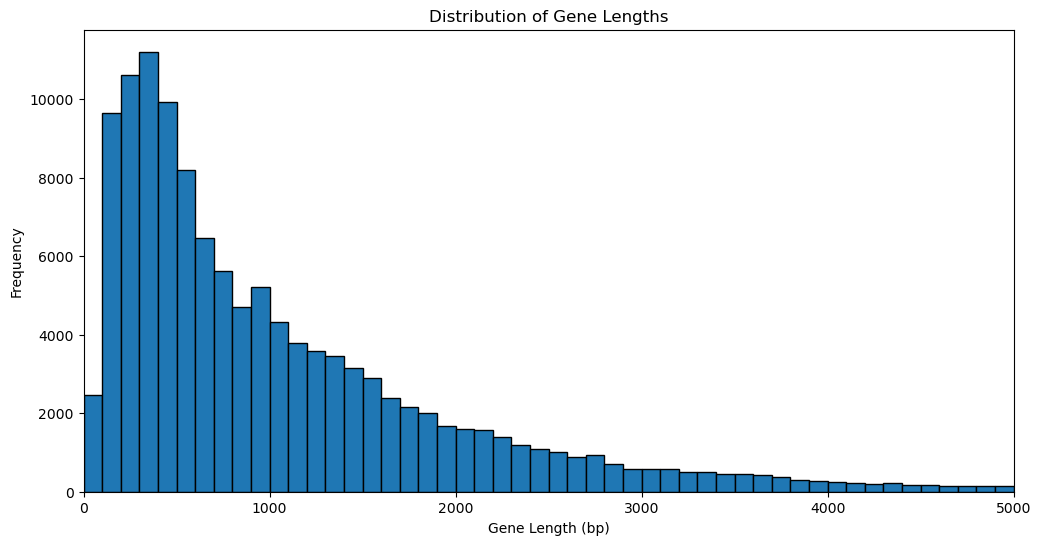

In [12]:
# Generate histogram of gene lengths
plt.figure(figsize=(12, 6))
plt.hist(gene_lengths, bins=50, edgecolor='black', range=(0, 5000))
plt.title('Distribution of Gene Lengths')
plt.xlabel('Gene Length (bp)')
plt.ylabel('Frequency')
plt.xlim(0, 5000)
plt.show()

In [13]:
ASE = antisense_ASE1

In [14]:
aligned_genes = check_alignment(ASE, gene_sequences=gene_sequence_dict)

In [15]:
# Download the mapping
mapping_df = download_ensembl_mapping()

In [16]:
if mapping_df is not None:
    # Create a dictionary for easy lookup
    mapping_dict = create_mapping_dict(mapping_df)

    # Print the first few entries of the mapping
    print("First few entries of the mapping:")
    for i, (transcript_id, gene_symbol) in enumerate(mapping_dict.items()):
        print(f"{transcript_id} -> {gene_symbol}")
        if i >= 4:  # Print only the first 5 entries
            break
    
    renamed_list = {}
    for enst_id, data in aligned_genes.items():
        gene_symbol = mapping_dict.get(enst_id, enst_id)  # Use original ID if not found in mapping
        renamed_list[gene_symbol] = data

    print("\nFirst few entries of the renamed list:")
    for entry in list(renamed_list.items())[:5]:  # Print only the first 5 entries
        print(entry)
else:
    print("Failed to download mapping. Please check your internet connection and try again.")

First few entries of the mapping:
ENST00000387314.1 -> MT-TF
ENST00000389680.2 -> MT-RNR1
ENST00000387342.1 -> MT-TV
ENST00000387347.2 -> MT-RNR2
ENST00000386347.1 -> MT-TL1

First few entries of the renamed list:
('TRDD1', {'score': 3.0, 'best_alignment': <Alignment object (2 rows x 3 columns) at 0x7f4364d09ad0>})
('TRDD3', {'score': 3.0, 'best_alignment': <Alignment object (2 rows x 3 columns) at 0x7f435d441b90>})
('TRDD2', {'score': 4.0, 'best_alignment': <Alignment object (2 rows x 4 columns) at 0x7f436a6e8f50>})
('TRBD1', {'score': 3.0, 'best_alignment': <Alignment object (2 rows x 3 columns) at 0x7f435d45c7d0>})
(nan, {'score': 5.0, 'best_alignment': <Alignment object (2 rows x 5 columns) at 0x7f43512a4190>})


In [17]:
aligned_genes = renamed_list

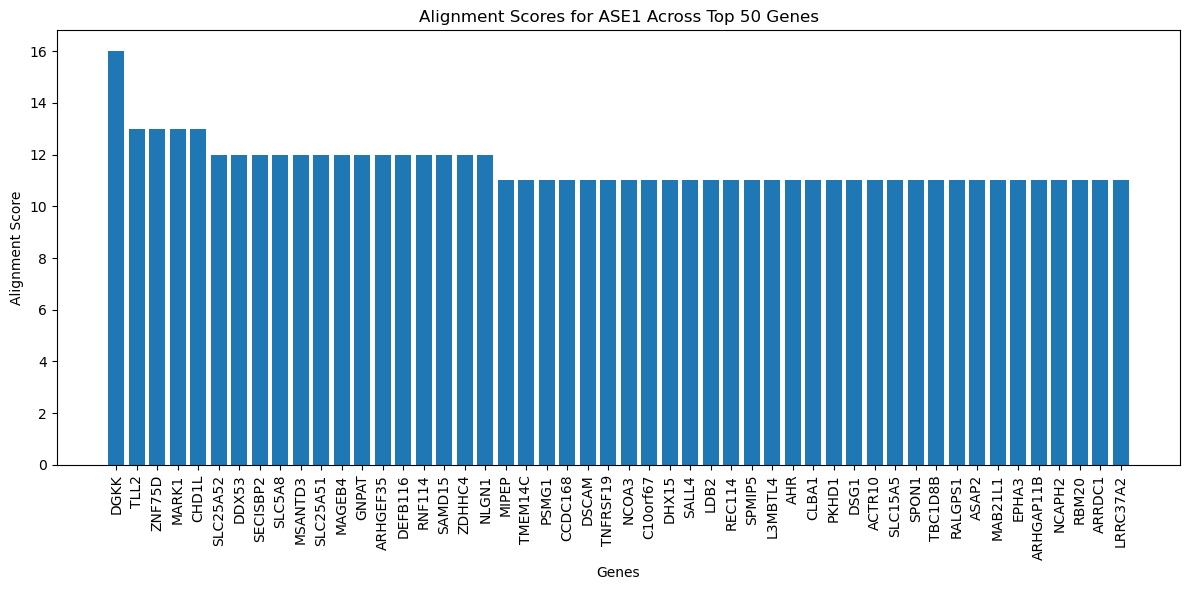

Average alignment score per gene: 6.90
Gene with highest score: DGKK
Gene with lowest score: SPATA3


In [18]:
# Extract scores from aligned_genes and sort them
scores = {gene: data['score'] for gene, data in aligned_genes.items()}
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

# Get the top 50 scored genes
top_50_scores = dict(list(sorted_scores.items())[:50])

# Visualize the top 50 sorted scores
plt.figure(figsize=(12, 6))
plt.bar(list(top_50_scores.keys()), list(top_50_scores.values()))
plt.title("Alignment Scores for ASE1 Across Top 50 Genes")
plt.xlabel("Genes")
plt.ylabel("Alignment Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and print some statistics
total_score = sum(scores.values())
avg_score = total_score / len(scores)
print(f"Average alignment score per gene: {avg_score:.2f}")
print(f"Gene with highest score: {next(iter(sorted_scores))}")
print(f"Gene with lowest score: {list(sorted_scores.keys())[-1]}")

In [19]:
# Get the top 5 genes with the highest score
top_5_genes = dict(sorted(aligned_genes.items(), key=lambda x: x[1]['score'], reverse=True)[:5])

for gene in top_5_genes.keys():
    print(gene)
    print(aligned_genes[gene]["best_alignment"])


DGKK
target            1 TTTTCCAAGGAATGTT   17
                  0 ||||||||||||||||   16
query          1332 TTTTCCAAGGAATGTT 1348

TLL2
target            3 TTCCAAGGAATGT   16
                  0 |||||||||||||   13
query          1457 TTCCAAGGAATGT 1470

ZNF75D
target            0 CTTTTCCAAGGAA  13
                  0 |||||||||||||  13
query           709 CTTTTCCAAGGAA 722

MARK1
target            0 CTTTTCCAAGGAA  13
                  0 |||||||||||||  13
query           348 CTTTTCCAAGGAA 361

CHD1L
target            0 CTTTTCCAAGGAA  13
                  0 |||||||||||||  13
query           455 CTTTTCCAAGGAA 468

